# **Obstacle Detection System**


In [6]:
import requests
import cv2
import numpy as np
import imutils
import os
import matplotlib.pyplot as plt

import copy
import math

import pdb
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights,MaskRCNN_ResNet50_FPN_V2_Weights
from pathlib import Path

import random


In [7]:
#hide plots or show images
hide_ui=False


In [8]:
number_of_colors = 30
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in color
]

weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT

def load_img(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

def display_image(image):
    fig, axes = plt.subplots(figsize=(12, 8))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(image)
    if(not hide_ui):
        plt.show()

def display_image_pair(first_image, second_image):
    # When using plt.subplots, we can specify how many plottable regions we want to create through nrows and ncols
    # Here, I am creating a subplot with 2 columns and 1 row (i.e. side-by-side axes)
    # When we do this, axes becomes a list of length 2 (Containing both plottable axes)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

    
    if first_image.ndim == 2:
        axes[0].imshow(first_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[0].imshow(first_image)

    if second_image.ndim == 2:
        axes[1].imshow(second_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[1].imshow(second_image)
    if(not hide_ui):
        plt.show()




def get_detections(model, imgs, score_threshold=0.5): 
    
    det = []
    lbls = []
    scores = []
    masks = []

    for img in imgs:
        with torch.no_grad():
            result = model(preprocess_image(img))[0]

        mask = result["scores"] > score_threshold

        boxes = result["boxes"][mask].detach().cpu().numpy()
        det.append(boxes)
        lbls.append(result["labels"][mask].detach().cpu().numpy())
        scores.append(result["scores"][mask].detach().cpu().numpy())
        masks.append(result["masks"][mask]) 

    # det is bounding boxes, lbls is class labels, scores are confidences and masks are segmentation masks.
    return det, lbls, scores, masks




#draws the bounding boxes
def draw_detections(img, det, colours=COLOURS, obj_order = None):
    for i, (tlx, tly, brx, bry) in enumerate(det):
        if obj_order is not None and len(obj_order) < i:
            i = obj_order[i]
        i %= len(colours)
        c = colours[i]
        
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)

def check_depth(img, det, lbls,depth,depth_std_map, conf=None, colours=COLOURS, class_map=weights.meta["categories"]):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[lbls[i]]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        
        offset = 1
     
        cx=math.floor((tlx+brx)/2)
        cy=math.floor((tly+bry)/2)
        depth_data=depth_std_map[tly:bry,tlx:brx].reshape(-1)
        depth_data=np.median(depth_data[depth_data>0])
        n=random.randint(0,2000)/10000
        depth[i]=depth_data-(depth_data*n)
        print( "check_depth car=> "+str(i)+" X Y => "+str(cx)+" "+str(cy)+" => "+str(depth[i])+" std "+str(depth_data))



#annotate the class labels
def annotate_class(img, det, lbls,depth,depth_std_map, conf=None, colours=COLOURS, class_map=weights.meta["categories"]):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[lbls[i]]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        
        offset = 1
        cv2.rectangle(img,
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=0)  

        ff = cv2.FONT_HERSHEY_PLAIN 
        cv2.rectangle(img, (brx-100, bry-30), (brx, bry-10), (255,255,255), -1)
        cx=math.floor((tlx+brx)/2)
        cy=math.floor((tly+bry)/2)
        depth_data=depth_std_map[tly:bry,tlx:brx].reshape(-1)
        depth_data=np.median(depth_data[depth_data>0])
        print( "car=> "+str(i)+" X,Y,stereo_depth,actual_depth => "+str(cx)+","+str(cy)+","+str(depth[i])+","+str(depth_data))
        cv2.putText(img,str(math.ceil(depth[i]))+'mt('+ str(i)+')', (brx-100, bry-12), fontFace=ff, fontScale=1, color=(120,0,0,255))


def centerOfArray(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+brx)/2
        cy = (tly+bry)/2
        points.append((cx, cy))
    return points

def reorderArray(array,reorderedIndex):
    points =[]
    for x in range(0,len(reorderedIndex)):
        points.append(array[reorderedIndex[x]])
    return np.array(points)

def findDepth(Baseline,alpha,focal_length,image_width):
    f_pixels=(image_width*0.5)/(np.tan(alpha*0.5*math.pi/180))
    depth=f_pixels*Baseline
    print("depth "+str(depth))
    return depth

def findClosest(left,right,threshold):
    points = []
    right_indices = []
    leftIndex=-1
    for leftX, leftY in left:
        leftIndex=leftIndex+1
        minValue=9999
        minIndex=-1
        index=-1
        for rightX, rightY in right:
            index=index+1
            distance=math.sqrt((rightX-leftX)*(rightX-leftX)+(rightY-leftY)*(rightY-leftY))
            if(distance<minValue and not (index in right_indices) and distance<threshold):
                minValue=distance
                minIndex=index
        if(minIndex!=-1):
            right_indices.append(minIndex)
            points.append((leftIndex,minIndex))
    return points



In [9]:
#The code in this cell reads the depth from the depth map. 
#This depth map has been created using LIDAR and is specific to the KITTI dataset. The code in this cell has been taken and adapted
# from "https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_scene_flow.zip" which is part of the official KITTI dataset website.

from PIL import Image
import numpy as np
import pandas as pd

def depth_read(filename):
    # loads depth map from png file
    # and returns it as a numpy array
    

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure to have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(float) / 256.   # in meters
    depth[depth_png == 0] = -1.
    return depth

In [10]:
path = ""
image_name="0000000008.png"
stereo_image_dir="./dataset/stereo/"
stereo_image_depth_dir="./dataset/depth/"
left_eye_dir=stereo_image_dir+"image_02/data/"
left_eye=left_eye_dir+image_name
right_eye_dir=stereo_image_dir+"image_03/data/"
right_eye=right_eye_dir+image_name
depth_filepath_left=stereo_image_depth_dir+"image_02/"+image_name

In [11]:
depth_std_map=depth_read(depth_filepath_left)

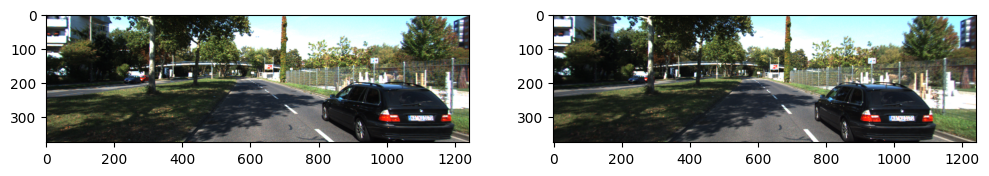

In [12]:
left_img = load_img(left_eye)
right_img = load_img(right_eye)
image_width = right_img.shape[1]
image_height_ = right_img.shape[0]
if(not hide_ui):
    display_image_pair(left_img, right_img)

In [13]:
imgs = [left_img, right_img]

left_right = [preprocess_image(d).squeeze(dim=0) for d in imgs]

print(right_img.shape)

(375, 1242, 3)


In [14]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)
_ = model.eval()

In [15]:
det, lbls, scores, masks = get_detections(model,imgs)

In [16]:
reordered_right_array=findClosest(centerOfArray(det[0]),centerOfArray(det[1]),image_width/10) # to match the contours in both images
left_indices=[x[0] for x in reordered_right_array]
right_indices=[x[1] for x in reordered_right_array]

det[0]=reorderArray(det[0],left_indices)
lbls[0]=reorderArray(lbls[0],left_indices)


det[1]=reorderArray(det[1],right_indices)
lbls[1]=reorderArray(lbls[1],right_indices)


In [17]:
det_left_final=centerOfArray(det[0])
det_right_final=centerOfArray(det[1])
det_left_final_X=[x[0] for x in det_left_final]
det_right_final_X=[x[0] for x in det_right_final]

In [18]:
disparity=abs(np.array(det_left_final_X)-np.array(det_right_final_X))
focal_length=645.24   
alpha = 56.6 
Baseline=54     
print("Disparity objectwise(0-9) "+str(disparity))
depth_of_objects=findDepth(Baseline,alpha,focal_length,image_width)/disparity

Disparity objectwise(0-9) [60.82598877  8.61767578 32.61956787]
depth 62279.39655348372


In [19]:
for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    check_depth(img,deti,lbls[i],depth_of_objects,depth_std_map)
    break

print("Depth of objects")
print(depth_of_objects)
print("left detections => ")
print(np.array(weights.meta["categories"])[lbls[0]])
print(det[0])
print("right detections => ")
print(np.array(weights.meta["categories"])[lbls[1]])
print(det[1])

check_depth car=> 0 X Y => 1003 284 => 6.955746875 std 7.4921875
check_depth car=> 1 X Y => 253 191 => 36.9839703125 std 42.359375
check_depth car=> 2 X Y => 288 189 => 40.938665625 std 45.24609375
Depth of objects
[ 6.95574687 36.98397031 40.93866562]
left detections => 
['car' 'car' 'car']
[[ 805.9871   199.30725 1201.9178   370.44113]
 [ 227.16205  179.34422  280.00992  204.39752]
 [ 275.6458   179.14648  302.96994  200.89815]]
right detections => 
['car' 'car' 'car']
[[ 765.5675   199.03525 1120.6855   370.20782]
 [ 218.2883   179.72603  271.64832  204.56754]
 [ 234.60231  167.05353  278.7743   196.1344 ]]


Image No 0
car=> 0 X,Y,stereo_depth,actual_depth => 1003,284,6.955746875,7.4921875
car=> 1 X,Y,stereo_depth,actual_depth => 253,191,36.9839703125,42.359375
car=> 2 X,Y,stereo_depth,actual_depth => 288,189,40.938665625,45.24609375
Image No 1
car=> 0 X,Y,stereo_depth,actual_depth => 942,284,6.955746875,8.388671875
car=> 1 X,Y,stereo_depth,actual_depth => 244,191,36.9839703125,42.28515625
car=> 2 X,Y,stereo_depth,actual_depth => 256,181,40.938665625,43.916015625


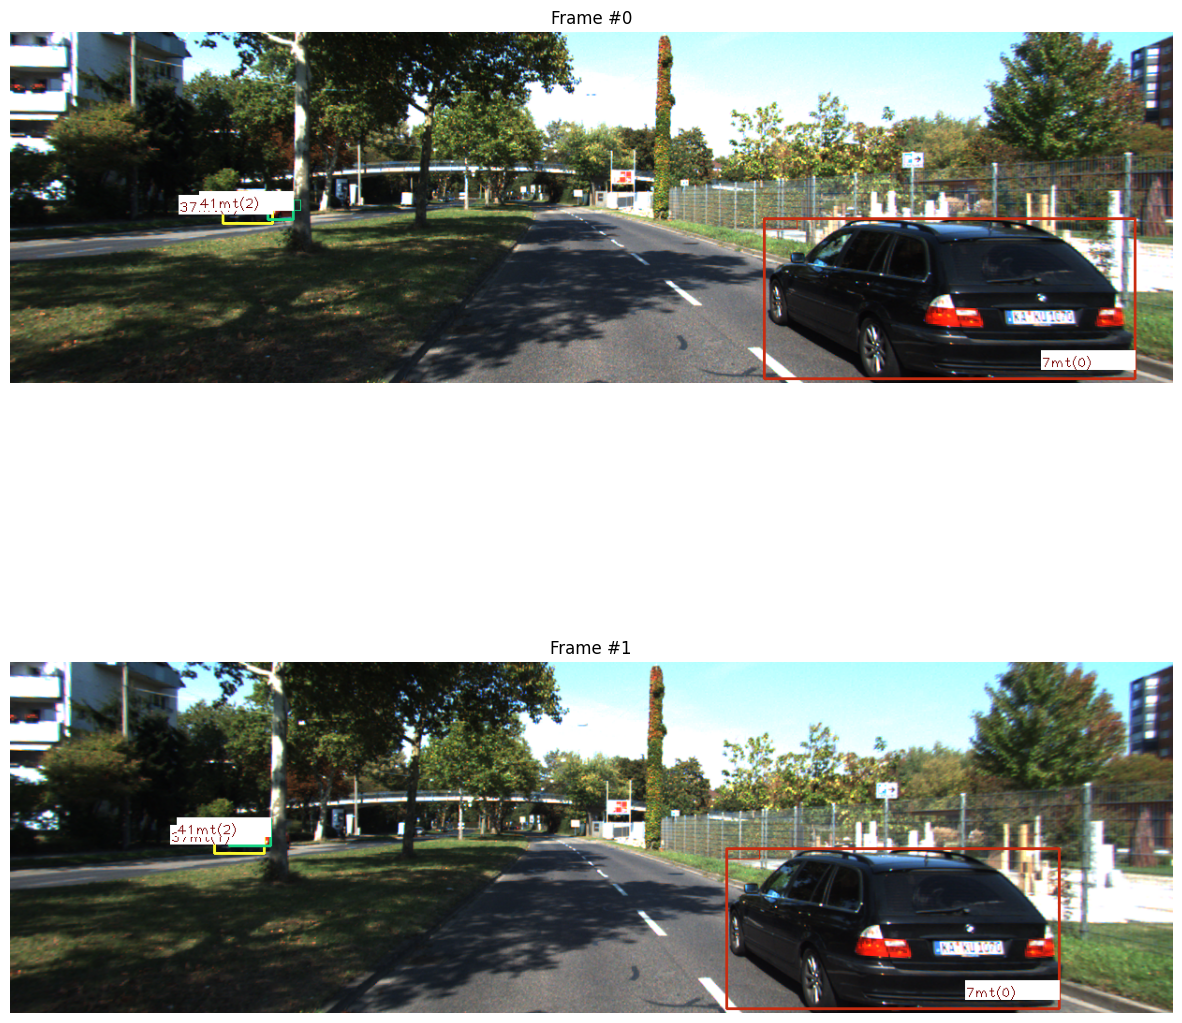

In [20]:
if(not hide_ui):
    fig, axes = plt.subplots(2, 1, figsize=(15,15))


for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    print("Image No "+str(i))
    draw_detections(img,deti)
    
    annotate_class(img,deti,lbls[i],depth_of_objects,depth_std_map)
    if(not hide_ui):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Frame #{i}')
if(not hide_ui):
    plt.show()